In [ ]:

import os
import glob
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchvision.transforms.v2 as v2
import torch.nn.functional as F

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint, TerminateOnNan
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Precision, Recall

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, roc_curve, auc)
import torch
import torchxrayvision as xrv
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

In [ ]:
common_diseases=['Pleural_Thickening',
    `        'Effusion',
            'Nodule',
            'Pneumothorax',
            'No Finding',
            'Consolidation',
            'Atelectasis',
            'Mass',
            'Infiltration']`
image_paths=glob.glob(record_path+r"\**\*.png",recursive=True)wwwqweqweqweqwe

In [15]:
df_test=pd.read_parquet("df_test.parquet")
df_test=df_test[["Image Index"]+[i for i in common_diseases]]
df_test=df_test.drop(columns="No Finding")
df_test

,Image Index,Pleural_Thickening,Effusion,Nodule,Pneumothorax,Consolidation,Atelectasis,Mass,Infiltration
38,00000013_000.png,0,0,0,0,0,0,0,0
39,00000013_001.png,0,0,0,1,0,0,0,0
40,00000013_002.png,0,0,0,1,0,0,0,0
41,00000013_003.png,1,0,0,0,0,0,0,0
42,00000013_004.png,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
112113,00030800_000.png,0,0,0,0,0,0,0,0
112116,00030802_000.png,0,0,0,0,0,0,0,0
112117,00030803_000.png,0,0,0,0,0,0,0,0
112118,00030804_000.png,0,0,0,0,0,0,0,0


In [135]:
import torchxrayvision as xrv
import skimage, torch, torchvision
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model from torchxrayvision
model = xrv.models.DenseNet(weights="densenet121-res224-nih")
model.to(device)
model.eval()
all_probs=[]
all_labels=[]
for i in range(len(df_test["Image Index"])):
    img_path = image_path_dict[df_test["Image Index"].iloc[i]]
    img = cv2.imread(img_path)
    img = xrv.datasets.normalize(img, 255) 
    img = img.mean(2)[None, ...] 
    transform = torchvision.transforms.Compose([xrv.datasets.XRayResizer(224, engine="cv2")])
    img = transform(img)
    img = torch.from_numpy(img).unsqueeze(0).to(device).float()
    with torch.no_grad():
        outputs = model(img)
    dict_probs = dict(zip(model.pathologies, outputs[0].cpu().numpy()))
    probs=[dict_probs[j] for j in common_diseases]
    label=df_test.iloc[i].to_numpy()[1:]
    all_probs.append(probs)
    all_labels.append(label)

Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
Setting 

In [136]:
logits_array = np.array(all_probs,dtype=object)
labels_array = np.array(all_labels,dtype=object)


Classification Report (Per-Class):
              precision    recall  f1-score   support

     Class 0       0.06      0.84      0.11      1060
     Class 1       0.27      0.87      0.41      4501
     Class 2       0.08      0.78      0.14      1544
     Class 3       0.12      0.85      0.22      2590
     Class 4       0.08      0.96      0.15      1724
     Class 5       0.16      0.89      0.27      3150
     Class 6       0.10      0.84      0.17      1667
     Class 7       0.25      0.93      0.39      5759

   micro avg       0.14      0.88      0.24     21995
   macro avg       0.14      0.87      0.23     21995
weighted avg       0.18      0.88      0.29     21995
 samples avg       0.13      0.49      0.19     21995


Confusion Matrix:
 [[6451  934 1307 1033  428  153   24 1476]
 [3500  412  100  129   36   10    1   19]
 [ 746   65  182   77   25   14    2   34]
 [1417   78  160   98   33    3    1   28]
 [ 729  155   49   63   10    1    0   11]
 [ 877  183  114  100   

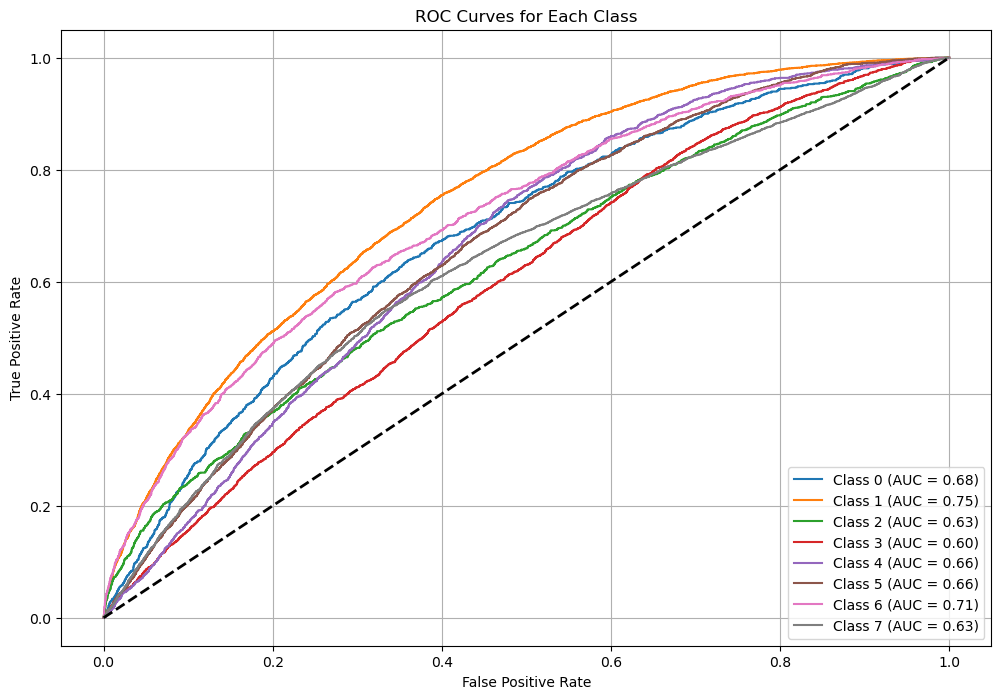

In [137]:
# Apply sigmoid to get probabilities
probs = logits_array
preds = (probs > 0.5).astype(int)

# %% [markdown]
# ## Metrics on Test Set

y_true = labels_array.astype(int)
y_pred = preds.astype(int)

print("\nClassification Report (Per-Class):")
print(
    classification_report(
        y_true, y_pred, 
        target_names=[f"Class {i}" for i in range(y_true.shape[1])]
    )
)

# Confusion matrix (argmax at the row level can be misleading for multi-label,
# but shown here for demonstration.)
cm = confusion_matrix(
    y_true.argmax(axis=1), 
    y_pred.argmax(axis=1)
)
print("\nConfusion Matrix:\n", cm)

# Element-wise binary accuracy
correct_predictions = (y_true == y_pred).sum()
total_predictions   = y_true.size
binary_accuracy     = correct_predictions / total_predictions
print(f"Binary Accuracy: {binary_accuracy:.4f}")

# %% [markdown]
# ## ROC Curves (Optional)

plt.figure(figsize=(12, 8))
for i in range(y_true.shape[1]):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
